Notebook for mask fraction analyses for cell-based coadds.

## Load in imports and data

Last working weekly: w2024_34

In [1]:
REPO = '/sdf/data/rubin/repo/main/'

from lsst.daf.butler import Butler
from pprint import pprint
import lsst.afw.image as afwImage
from lsst.skymap import Index2D
import numpy as np
import matplotlib as mpl
from matplotlib import pyplot as plt

%matplotlib inline

butler = Butler(REPO)
registry = butler.registry

# define image display backend
import lsst.afw.display as afwDisplay
afwDisplay.setDefaultBackend('firefly')

# cell variance
import numpy.ma as ma

# mean weighted variance
from lsst.drp.tasks.assemble_cell_coadd import AssembleCellCoaddTask
import lsst.afw.math as afwMath

# plotting image with cell inputs
import lsst.geom as afwGeom

# interpolation mask threshold
import lsst.geom as geom

Confirm which version of packages are setup on the notebook environment.

In [2]:
# collection = 'u/mgorsuch/assemble_cell_coadd_patch_61_d0508' # updated patch 61 collection
collection = 'u/mgorsuch/assemble_cell_coadds_tract_9813/20240624T164450Z' # all working patches in tract 9813

In [3]:
patch = 50

In [4]:
coadd = butler.get('deepCoaddCell', 
                     collections=collection, 
                     instrument='HSC', 
                     skymap = 'hsc_rings_cells_v1', 
                     tract = 9813, 
                     patch=patch,
                     band='i',)

In [5]:
# stitch_coadd = coadd.stitch() # fails with empty cells
explode_coadd = coadd.explode()

In [6]:
cell_list_filled = list(coadd.cells.keys())

In [7]:
cell_list = []
cells_filled = [False] * 484

index = 0
for i in range(22):
    for j in range(22):
        cell_list.append(Index2D(x=j,y=i))

        for cell in cell_list_filled:
            if (j==cell.x) and (i==cell.y):
                cells_filled[index]=True

        index += 1

In [8]:
# example on how to use equivalent of np.where on lists
# cell_list_test = [cell_list[index] for index, val in enumerate(cells_filled) if val == True]

In [9]:
visits = []
for ref in butler.registry.queryDatasets('deepCoadd_directWarp', physical_filter='HSC-I', collections=collection, instrument='HSC', tract=9813, skymap = 'hsc_rings_cells_v1', patch=patch):
    visits.append(ref.dataId.get('visit'))
visits = np.unique(visits)

In [10]:
# arrange the number of inputs for each cell into a 2D grid:
x_cell_bin = np.arange(0,22+1,1)
y_cell_bin = np.arange(0,22+1,1)

inputs_list = np.zeros([22,22])

# for cell in cell_list:
for index, cell in enumerate(cell_list):

    # check if the cell is filled, skip if not
    if not (cells_filled[index]):
        continue 
        
    num_cell_inputs = len(coadd.cells[cell].inputs)
    x_index = cell.x
    y_index = cell.y
        
    inputs_list[y_index][x_index] = num_cell_inputs

In [11]:
# create and configure stats control object as seen in assemble_cell_coadd task
statsCtrl = afwMath.StatisticsControl()
statsCtrl.setAndMask(afwImage.Mask.getPlaneBitMask(("BAD", "NO_DATA", "SAT"))) # use default PlaneBitMasks from task
statsCtrl.setNanSafe(True)

## Variation in INTRP mask fraction

### Create total input warp map (exclude inputs with `EDGE` mask)

Find a way to either load/calculate total number of possible input warps per cell prior to mask information.

Warps are currently thrown out in `AssembleCellCoaddTask` for:
- `EDGE` mask within cell bounding box
- weight of warp input image is not finite

There is currently no implementation for other masks.

Iteratite through the input warps and count which ones are considered for each cell. Only exclude warps with overlapping `EDGE` masks within cells. Other mask fractions will remove from total inputs early.

In [12]:
accTask = AssembleCellCoaddTask()

total_inputs_list = np.zeros([22,22])
edge = afwImage.Mask.getPlaneBitMask("EDGE")

for warp_visit in visits:
    warp = butler.get('deepCoadd_directWarp',
                       collections = collection,
                       instrument='HSC',
                       skymap = 'hsc_rings_cells_v1',
                       tract = 9813,
                       patch = patch,
                       visit = warp_visit)
 
    for index, cell_index in enumerate(cell_list):

        # check if the cell is filled, skip if not
        if not (cells_filled[index]):
            continue 
        
        cell = coadd.cells[cell_index]
        
        bbox = cell.outer.bbox
        masked_im = warp[bbox].getMaskedImage()

        # check if the warp covers the cell
        if (masked_im.getMask().array & edge).any():
            continue

        # ensure that weights are finite, skip cell if not
        weight = accTask._compute_weight(masked_im, statsCtrl)
        if not np.isfinite(weight):
            continue

        x_index = cell_index.x
        y_index = cell_index.y
        total_inputs_list[y_index][x_index] += 1
        
    del warp

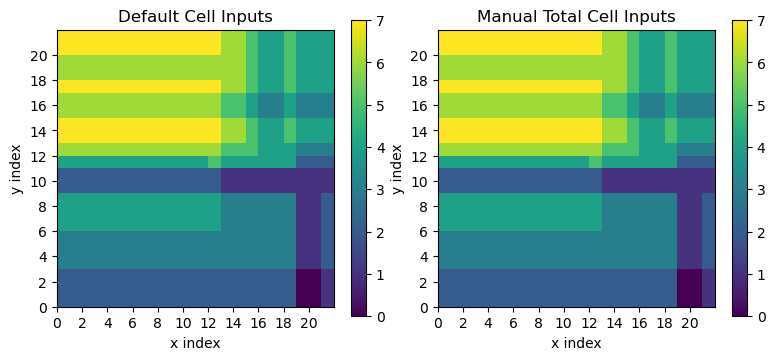

In [13]:
x_cell_bin = np.arange(0,22+1,1)
y_cell_bin = np.arange(0,22+1,1)

fig,(ax1, ax2) = plt.subplots(1, 2, figsize=(8,8))
plt.tight_layout()
plt.subplots_adjust(wspace=0.1)

cell_inputs = ax1.pcolormesh(x_cell_bin, 
                             y_cell_bin, 
                             inputs_list, 
                             shading='auto', 
                             vmin=inputs_list.min(), 
                             vmax=inputs_list.max())

ax1.set_title(f"Default Cell Inputs")
ax1.set_xlabel("x index")
ax1.set_ylabel("y index")
ax1.set_aspect('equal')
ax1.set_xticks(np.arange(0, 21, 2))
ax1.set_yticks(np.arange(0, 21, 2))

fig.colorbar(cell_inputs, ax=ax1, cmap='viridis', shrink=0.4)

cell_total_inputs = ax2.pcolormesh(x_cell_bin, 
                                   y_cell_bin,
                                   total_inputs_list, 
                                   shading='auto', 
                                   vmin=total_inputs_list.min(), 
                                   vmax=total_inputs_list.max(),)

ax2.set_title(f"Manual Total Cell Inputs")
ax2.set_xlabel("x index")
ax2.set_ylabel("y index")
ax2.set_aspect('equal')
ax2.set_xticks(np.arange(0, 21, 2))
ax2.set_yticks(np.arange(0, 21, 2))

fig.colorbar(cell_total_inputs, ax=ax2, cmap='viridis', shrink=0.4)

plt.show()

Now it's apparant that the default number of cell inputs that come from running the tasks produce the total number of considered inputs. It's time to rerun the above, but calculate a test mask fraction for interpolation effects.

### Implement mask fraction for interpolation

In [14]:
accTask = AssembleCellCoaddTask()

weighted_mask_frac1 = np.zeros([22,22])
cell_inputs1 = np.zeros([22,22])
cell_inputs2 = np.zeros([22,22])
intrp = afwImage.Mask.getPlaneBitMask("INTRP")

for visit in visits:
    warp = butler.get('deepCoadd_directWarp',
                       collections = collection,
                       instrument='HSC',
                       skymap = 'hsc_rings_cells_v1',
                       tract = 9813,
                       patch = patch,
                       visit = visit)
    
    mask_frac_warp = butler.get('deepCoadd_directWarp_maskedFraction',
                       collections = collection,
                       instrument='HSC',
                       skymap = 'hsc_rings_cells_v1',
                       tract = 9813,
                       patch = patch,
                       visit = visit)

    for index, cell_index in enumerate(cell_list):
        
        # check if the cell is filled, skip if not
        if not (cells_filled[index]):
            continue
            
        cell = coadd.cells[cell_index]
        
        bbox = cell.outer.bbox
        masked_im = warp[bbox].getMaskedImage()
        mask_frac_im = mask_frac_warp[bbox].array

        # check if cell uses warp, skip cell if not
        cell_inputs = list(cell.inputs)
        cell_visits = [input.visit for input in cell_inputs]
        if not (np.isin(visit, cell_visits)):
            continue

        # skip warp for this cell if intrp mask fraction is too high
        total_pixels = bbox.area
        mask_frac = np.nansum(mask_frac_im[np.where(np.isfinite(mask_frac_im))])/total_pixels

        if mask_frac >= 0.85:
            print("mask frac reached")
            continue

        # coadd the weighted mask fraction for this cell
        input_weight = accTask._compute_weight(masked_im, statsCtrl)
        weight_mask_frac = input_weight * mask_frac_im
        
        x_index = cell_index.x
        y_index = cell_index.y

        weighted_mask_frac1[y_index][x_index] += np.nansum(weight_mask_frac) / total_pixels
        
        if mask_frac >= 0.10:
            continue
            
        cell_inputs1[y_index][x_index] += 1

        if mask_frac >= 0.05:
            continue
    
        cell_inputs2[y_index][x_index] += 1

    del warp
    del mask_frac_warp

inputs_list_masked = ma.masked_where(inputs_list == 0.0, inputs_list)
cell_input_frac1 = cell_inputs1 / inputs_list_masked
cell_input_frac2 = cell_inputs2 / inputs_list_masked
weighted_mask_frac1 = ma.masked_where(inputs_list == 0.0, weighted_mask_frac1)

Cut out the exta 50 empty side pixels in the stitched coadd.

In [15]:
# bbox = afwGeom.Box2I()
# bbox.include(afwGeom.Point2I(stitch_coadd.bbox.getBegin()+(geom.Extent2I(50, 50))))
# bbox.include(afwGeom.Point2I(stitch_coadd.bbox.getMax()-(geom.Extent2I(50, 50))))
# cutout = stitch_coadd.asExposure()[bbox]

# extent = 0, cutout.getDimensions()[0], 0, cutout.getDimensions()[1]

In [16]:
bbox = afwGeom.Box2I()
bbox.include(afwGeom.Point2I(explode_coadd.bbox.getBegin()+(geom.Extent2I(50, 50))))
bbox.include(afwGeom.Point2I(explode_coadd.bbox.getMax()-(geom.Extent2I(50, 50))))
cutout = explode_coadd.image[bbox]

extent = 0, cutout.getDimensions()[0], 0, cutout.getDimensions()[1]

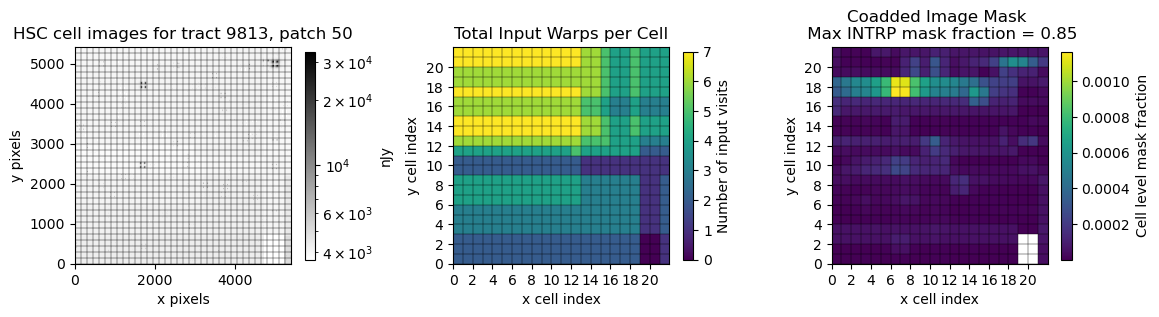

In [17]:
x_cell_bin = np.arange(0,22+1,1)
y_cell_bin = np.arange(0,22+1,1)

fig, axs = plt.subplots(1, 3, figsize=(11,11))
plt.tight_layout()
plt.subplots_adjust(wspace=0.4, hspace=0.05)

stitched_image = axs[0].imshow(np.flip(cutout.array, axis=0),
                                 cmap='gray_r',
                                 norm='log',
                                 extent=extent,)

hlines = [axs[0].axhline(y=i, linestyle='-', lw=0.3, color='black') for i in range(0, cutout.getDimensions()[0], 150)]
vlines = [axs[0].axvline(x=i, linestyle='-', lw=0.3, color='black') for i in range(0, cutout.getDimensions()[0], 150)]

axs[0].set_title(f"HSC cell images for tract 9813, patch {patch}")
axs[0].set_xlabel("x pixels")
axs[0].set_ylabel("y pixels")
axs[0].set_aspect('equal')

fig.colorbar(stitched_image, ax=axs[0], cmap='viridis', shrink=0.2, label="nJy")

cell_inputs = axs[1].pcolormesh(x_cell_bin, 
                             y_cell_bin, 
                             inputs_list, 
                             shading='auto', 
                             vmin=inputs_list.min(), 
                             vmax=inputs_list.max())

hlines = [axs[1].axhline(y=i, linestyle='-', lw=0.3, color='black') for i in range(0, 22)]
vlines = [axs[1].axvline(x=i, linestyle='-', lw=0.3, color='black') for i in range(0, 22)]

axs[1].set_title(f"Total Input Warps per Cell")
axs[1].set_xlabel("x cell index")
axs[1].set_ylabel("y cell index")
axs[1].set_aspect('equal')
axs[1].set_xticks(np.arange(0, 21, 2))
axs[1].set_yticks(np.arange(0, 21, 2))

fig.colorbar(cell_inputs, ax=axs[1], cmap='viridis', shrink=0.2, label="Number of input visits")

cell_mask_frac1 = axs[2].pcolormesh(x_cell_bin, 
                                   y_cell_bin,
                                   weighted_mask_frac1,
                                   shading='auto', 
                                   vmin=weighted_mask_frac1.min(), 
                                   vmax=weighted_mask_frac1.max(),)

hlines = [axs[2].axhline(y=i, linestyle='-', lw=0.3, color='black') for i in range(0, 22)]
vlines = [axs[2].axvline(x=i, linestyle='-', lw=0.3, color='black') for i in range(0, 22)]

axs[2].set_title(f"Coadded Image Mask \n Max INTRP mask fraction = 0.85")
axs[2].set_xlabel("x cell index")
axs[2].set_ylabel("y cell index")
axs[2].set_aspect('equal')
axs[2].set_xticks(np.arange(0, 21, 2))
axs[2].set_yticks(np.arange(0, 21, 2))

fig.colorbar(cell_mask_frac1, ax=axs[2], cmap='viridis', shrink=0.2, label="Cell level mask fraction")

# plt.savefig("image_outputs/2d-weighted-mask-fraction.png", bbox_inches='tight')
plt.show()

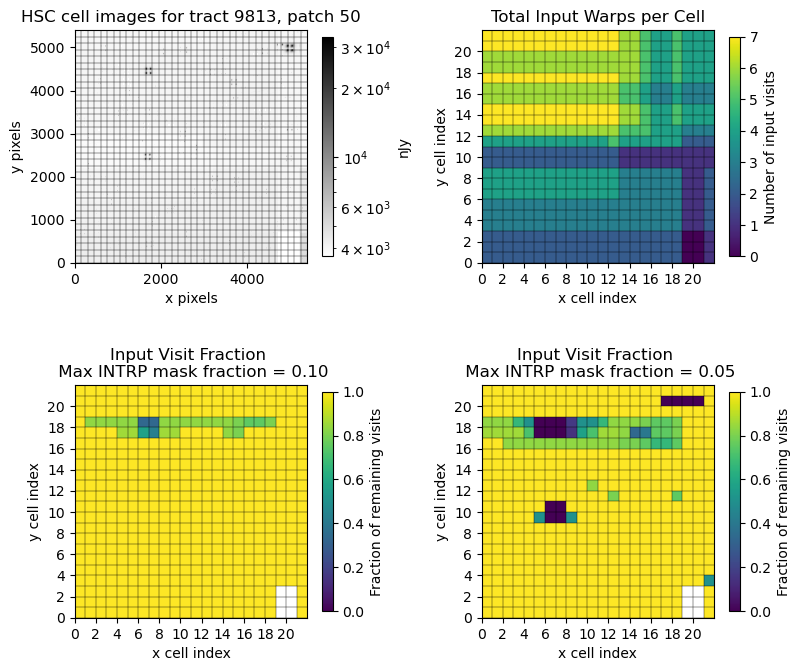

In [18]:
x_cell_bin = np.arange(0,22+1,1)
y_cell_bin = np.arange(0,22+1,1)

fig, axs = plt.subplots(2, 2, figsize=(9,9))
plt.subplots_adjust(wspace=0.4, hspace=0.05)

stitched_image = axs[0,0].imshow(np.flip(cutout.array, axis=0), 
                                 cmap='gray_r',
                                 norm='log',
                                 extent=extent,)

hlines = [axs[0,0].axhline(y=i, linestyle='-', lw=0.3, color='black') for i in range(0, cutout.getDimensions()[0], 150)]
vlines = [axs[0,0].axvline(x=i, linestyle='-', lw=0.3, color='black') for i in range(0, cutout.getDimensions()[0], 150)]

axs[0,0].set_title(f"HSC cell images for tract 9813, patch {patch}")
axs[0,0].set_xlabel("x pixels")
axs[0,0].set_ylabel("y pixels")
axs[0,0].set_aspect('equal')

fig.colorbar(stitched_image, ax=axs[0,0], cmap='viridis', shrink=0.65, label="nJy")

cell_inputs = axs[0,1].pcolormesh(x_cell_bin, 
                             y_cell_bin, 
                             inputs_list, 
                             shading='auto', 
                             vmin=inputs_list.min(), 
                             vmax=inputs_list.max())

hlines = [axs[0,1].axhline(y=i, linestyle='-', lw=0.3, color='black') for i in range(0, 22)]
vlines = [axs[0,1].axvline(x=i, linestyle='-', lw=0.3, color='black') for i in range(0, 22)]

axs[0,1].set_title(f"Total Input Warps per Cell")
axs[0,1].set_xlabel("x cell index")
axs[0,1].set_ylabel("y cell index")
axs[0,1].set_aspect('equal')
axs[0,1].set_xticks(np.arange(0, 21, 2))
axs[0,1].set_yticks(np.arange(0, 21, 2))

fig.colorbar(cell_inputs, ax=axs[0,1], cmap='viridis', shrink=0.65, label="Number of input visits")

cell_mask_frac1 = axs[1,0].pcolormesh(x_cell_bin, 
                                   y_cell_bin,
                                   cell_input_frac1, 
                                   shading='auto', 
                                   vmin=0, 
                                   vmax=1,)

hlines = [axs[1,0].axhline(y=i, linestyle='-', lw=0.3, color='black') for i in range(0, 22)]
vlines = [axs[1,0].axvline(x=i, linestyle='-', lw=0.3, color='black') for i in range(0, 22)]

axs[1,0].set_title(f"Input Visit Fraction \n Max INTRP mask fraction = 0.10")
axs[1,0].set_xlabel("x cell index")
axs[1,0].set_ylabel("y cell index")
axs[1,0].set_aspect('equal')
axs[1,0].set_xticks(np.arange(0, 21, 2))
axs[1,0].set_yticks(np.arange(0, 21, 2))

fig.colorbar(cell_mask_frac1, ax=axs[1,0], cmap='viridis', shrink=0.65, label="Fraction of remaining visits")

cell_mask_frac2 = axs[1,1].pcolormesh(x_cell_bin, 
                                       y_cell_bin,
                                       cell_input_frac2, 
                                       shading='auto', 
                                       vmin=0, 
                                       vmax=1,)

hlines = [axs[1,1].axhline(y=i, linestyle='-', lw=0.3, color='black') for i in range(0, 22)]
vlines = [axs[1,1].axvline(x=i, linestyle='-', lw=0.3, color='black') for i in range(0, 22)]

axs[1,1].set_title(f"Input Visit Fraction \n Max INTRP mask fraction = 0.05")
axs[1,1].set_xlabel("x cell index")
axs[1,1].set_ylabel("y cell index")
axs[1,1].set_aspect('equal')
axs[1,1].set_xticks(np.arange(0, 21, 2))
axs[1,1].set_yticks(np.arange(0, 21, 2))

fig.colorbar(cell_mask_frac2, ax=axs[1,1], cmap='viridis', shrink=0.65, label="Fraction of remaining visits")

# plt.savefig("image_outputs/2d-mask-fraction.png", bbox_inches='tight')
plt.show()

### Mask Fraction Function

Get the mask fraction for each warp in each of the cells.
Should only have to run once per notebook session.

In [19]:
accTask = AssembleCellCoaddTask()

warp_mask_fractions = [np.zeros([22,22]) for i in np.arange(len(visits))]

intrp = afwImage.Mask.getPlaneBitMask("INTRP")

for index, visit in enumerate(visits):
    warp = butler.get('deepCoadd_directWarp',
                       collections = collection,
                       instrument='HSC',
                       skymap = 'hsc_rings_cells_v1',
                       tract = 9813,
                       patch = patch,
                       visit = visit)
    
    mask_frac_warp = butler.get('deepCoadd_directWarp_maskedFraction',
                       collections = collection,
                       instrument='HSC',
                       skymap = 'hsc_rings_cells_v1',
                       tract = 9813,
                       patch = patch,
                       visit = visit)
    
    cell_grid = np.zeros([22,22])

    for index_check, cell_index in enumerate(cell_list):
        
        # check if the cell is filled, skip if not
        if not (cells_filled[index_check]):
            continue

        cell = coadd.cells[cell_index]

        x_index = cell_index.x
        y_index = cell_index.y
        
        bbox = cell.outer.bbox
        masked_im = warp[bbox].getMaskedImage()
        mask_frac_im = mask_frac_warp[bbox].array

        # check if cell uses warp, skip cell if not
        cell_inputs = list(cell.inputs)
        cell_visits = [input.visit for input in cell_inputs]
        if not (np.isin(visit, cell_visits)):
            cell_grid[y_index][x_index] = -1.0
            continue
    
        # calculate fraction of masked pixels for the area of the warp that covers this cell
        total_pixels = bbox.area
        mask_frac = np.nansum(mask_frac_im[np.where(np.isfinite(mask_frac_im))])/total_pixels
    
        cell_grid[y_index][x_index] = mask_frac

    warp_mask_fractions[index] = cell_grid

    del warp
    del mask_frac_warp

Iterate through the each max mask threshold to see how number of inputs change

In [20]:
max_mask_frac_list = np.arange(0.01, 0.20, 0.02)
cell_inputs_grid_total = [np.zeros([22,22]) for i in np.arange(len(max_mask_frac_list))]

intrp = afwImage.Mask.getPlaneBitMask("INTRP")

for warp_index, warp_mask_fraction in enumerate(warp_mask_fractions):

    for index, max_mask_frac in enumerate(max_mask_frac_list):
    
        cell_inputs_grid = np.zeros([22,22])

        for index_check, cell_index in enumerate(cell_list):
        
            # check if the cell is filled, skip if not
            if not (cells_filled[index_check]):
                continue
                
            x_index = cell_index.x
            y_index = cell_index.y

            mask_frac = warp_mask_fraction[y_index][x_index]

            # skip this warp if cell is not in warp (defined with -1)
            if (mask_frac == -1.0):
                continue

            # skip this warp if its mask fraction is over the threshold
            if mask_frac >= max_mask_frac:
                continue
            
            # add one input to this cell if the warp passes mask criteria
            cell_inputs_grid[y_index][x_index] += 1

        # add the 22 x 22 cell grid for this mask threshold to the list of cell grids
        cell_inputs_grid_total[index] += cell_inputs_grid

inputs_list_masked = ma.masked_where(inputs_list == 0.0, inputs_list)
cell_inputs_grid_total = [array.flatten() for array in cell_inputs_grid_total]
cell_inputs_remaining_frac = [(array/inputs_list_masked.flatten()) for array in cell_inputs_grid_total]
cell_inputs_removed_frac = [(1-(array/inputs_list_masked.flatten())) for array in cell_inputs_grid_total]

cell_inputs_grid_mean_total = [np.mean(array) for array in cell_inputs_grid_total]
cell_inputs_mean_remaining_frac = [np.mean(array) for array in cell_inputs_remaining_frac]
cell_inputs_mean_removed_frac = [np.mean(array) for array in cell_inputs_removed_frac]

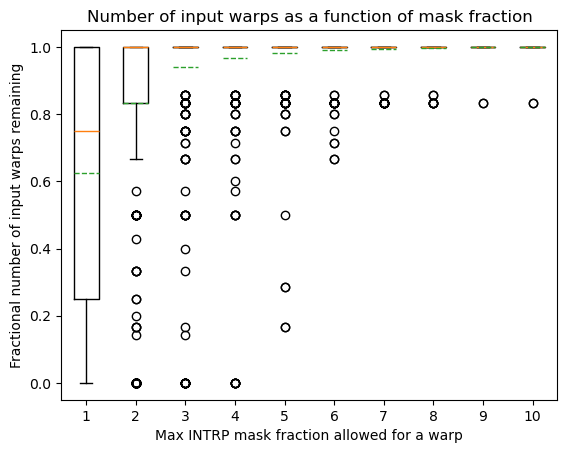

In [21]:
fig, ax = plt.subplots()
bplot = ax.boxplot(cell_inputs_remaining_frac, 
                   showmeans = True,
                   meanline = True,)
ax.set_title("Number of input warps as a function of mask fraction")
ax.set_xlabel("Max INTRP mask fraction allowed for a warp")
ax.set_ylabel("Fractional number of input warps remaining")
#ax.set_yscale("log")
plt.show()

Try a culminative version of the plot above (squish information down into one value for each mask fraction)

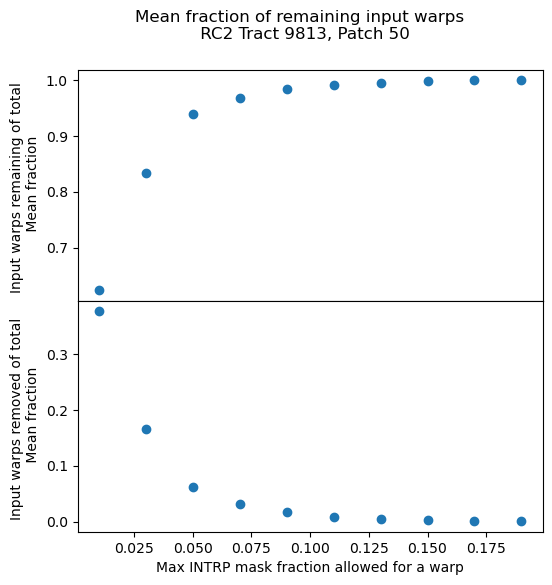

In [22]:
fig, axs = plt.subplots(2, 1, figsize=(6,6), sharex=True)

#plt.tight_layout(pad=0)
# plt.subplots_adjust(wspace=0.0, hspace=0.0)
fig.subplots_adjust(hspace=0)
fig.suptitle(f"Mean fraction of remaining input warps \n RC2 Tract 9813, Patch {patch}")

remaining = axs[0].scatter(max_mask_frac_list, cell_inputs_mean_remaining_frac,)
axs[0].set_ylabel("Input warps remaining of total \n Mean fraction")
#ax.set_xscale("log")

removed = axs[1].scatter(max_mask_frac_list, cell_inputs_mean_removed_frac,)
axs[1].set_xlabel("Max INTRP mask fraction allowed for a warp")
axs[1].set_ylabel("Input warps removed of total \n Mean fraction")

plt.show()

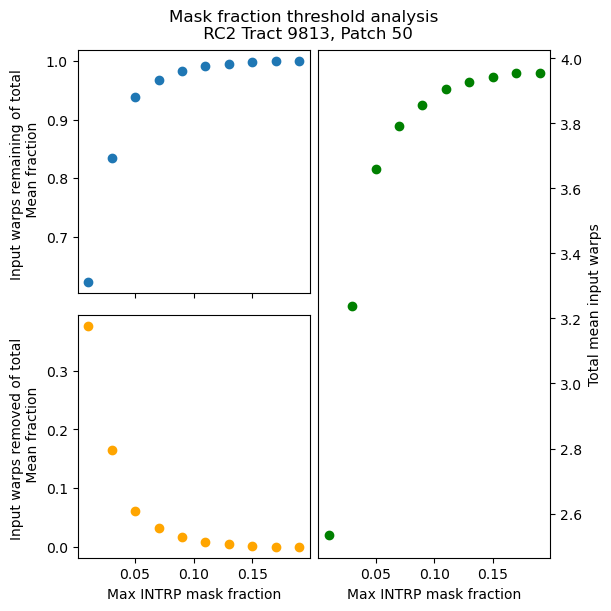

In [23]:
fig, axd = plt.subplot_mosaic([['remain', 'total'],
                               ['removed', 'total']],
                              figsize=(6, 6), layout="constrained", sharex=True)

fig.suptitle(f"Mask fraction threshold analysis \n RC2 Tract 9813, Patch {patch}")

axd['remain'].scatter(max_mask_frac_list, cell_inputs_mean_remaining_frac,)
axd['remain'].set_ylabel("Input warps remaining of total \n Mean fraction")

axd['removed'].scatter(max_mask_frac_list, cell_inputs_mean_removed_frac, color='orange')
axd['removed'].set_xlabel("Max INTRP mask fraction")
axd['removed'].set_ylabel("Input warps removed of total \n Mean fraction")

axd['total'].scatter(max_mask_frac_list, cell_inputs_grid_mean_total, color='green')
axd['total'].set_xlabel("Max INTRP mask fraction")
axd['total'].set_ylabel("Total mean input warps")
axd['total'].yaxis.set_label_position("right")
axd['total'].yaxis.tick_right()
# axd['total'].set_ylabel("Input warps removed of total \n Mean fraction")

plt.show()